In [5]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import expit
from sklearn.linear_model import LinearRegression
import pickle
from scipy.special import expit, logit
warnings.filterwarnings("ignore", category=FutureWarning)

In [14]:
# versions

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

arviz==0.17.0
numpy==1.26.4
pandas==2.2.1
seaborn==0.13.2


In [17]:
cat_cols = ["sex", "weird", "rater", "field", "new_rater_disc", "abstract", "doctype"]

df = pd.read_csv(
    r"C:\Users\conix\Dropbox\aWriting\humanities impact\follow up study\combined_data.csv",
    dtype={i: "category" for i in cat_cols},
    index_col=0,
)



content_codes = [
    "fiction",
    "intolerance",
    "ethics",
    "empirical",
    "environment",
    "education",
    "wellbeing",
    "deliverable",
]

content_params = content_codes + ["doctype"]
fields_order = ["History", "Philosophy", "Religion", "Linguistics", "Literature"]
fields_names = ["History", "Linguistics", "Literature", "Philosophy", "Religion"]
rater_fields_names = [
    "History",
    "Linguistics",
    "Literature",
    "Philosophy",
    "Religion",
    "non-humanities",
]

print(f"columns: {df.columns.values}")
print("")
df.head(2)

columns: ['original_index' 'doi' 'title' 'abstract_text' 'pubyear' 'doctype'
 'rater' 'block' 'field' 'ordinal' 'binary' 'group' 'rater_disc'
 'nationality' 'sex' 'weird' 'field_group' 'abstract' 'chauvinism'
 'present' 'intolerance' 'ethics' 'empirical' 'environment' 'fiction'
 'education' 'wellbeing' 'deliverable' 'capture' 'citation' 'socialmedia'
 'mention' 'outlier' 'usage' 'abstract_length' 'abstract_wordcount'
 'abstract_length_norm' 'humanities' 'new_rater_disc']



,original_index,doi,title,abstract_text,pubyear,doctype,rater,block,field,ordinal,...,citation,socialmedia,mention,outlier,usage,abstract_length,abstract_wordcount,abstract_length_norm,humanities,new_rater_disc
0,0.0,10.1080/09523367.2015.1022721,Does China Matter? Taiwan's Successful Bid to ...,This study seeks to identify and explain the k...,2015,Article,151_main,QID1_1_main,History,3,...,NaN,NaN,NaN,NaN,NaN,937,134,-0.285797,1,History
1,0.0,10.1080/09523367.2015.1022721,Does China Matter? Taiwan's Successful Bid to ...,This study seeks to identify and explain the k...,2015,Article,111_main,QID1_1_main,History,2,...,NaN,NaN,NaN,NaN,NaN,937,134,-0.285797,1,Philosophy


# Do ordinal and binary scores correlate?

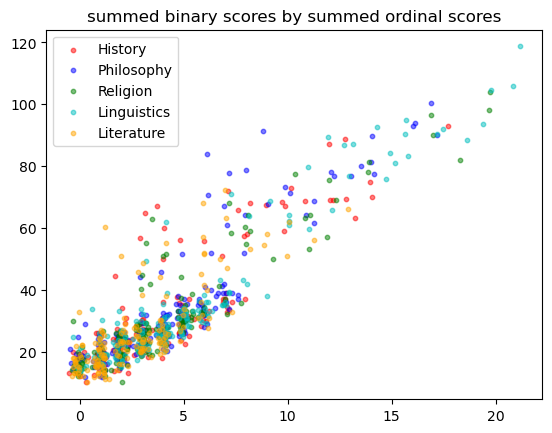

In [38]:
# do ordinal and binary data make sense?

colors = ['r','b','g','c','orange']

for i in range(5):
    summed_scores = df.loc[df.field == df.field.unique()[i]].groupby('doi')[['binary','ordinal']].sum()

    # add a bit of jitter to avoid overlap
    jitter_amount = 0.2
    x = summed_scores['binary'] + np.random.normal(0, jitter_amount, size=len(summed_scores))
    y = summed_scores['ordinal'] + np.random.normal(0, jitter_amount, size=len(summed_scores))
    
    plt.scatter(x, y, s = 10,color = colors[i], alpha = 0.5)
    
plt.title('summed binary scores by summed ordinal scores')
plt.legend(df.field.unique())
plt.show()

# Why is the proportion in g2 so low?

In [ ]:
tc = az.from_netcdf(
    r"C:\Users\conix\Documents\IIH_localtraces\trace_chauvinism_thurstonian_all.nc"
)

In [13]:
for i in ["group1", "group2", "main"]:
    print(f"{i} proportion: {df.loc[df.group == i]['binary'].mean()}")

group1 proportion: 0.391304347826087
group2 proportion: 0.3279503105590062
main proportion: 0.4257575757575758


## Check strictness

In [14]:
# might it be strictness? Check the means

for i in ["g1strictness", "g2strictness", "mstrictness"]:
    print(f"{i} mean strictness: {tc.posterior[i].values.mean()}")

g1strictness mean strictness: -0.27429641649002956
g2strictness mean strictness: -0.7786868961865926
mstrictness mean strictness: 0.1259083992384313


In [15]:
# sample random strictness values, and highlight the real cases in there
random_sds = np.random.choice(
    np.ravel(tc.posterior["strictness_sd"].values), 1000, replace=True
)
strictnesses = np.random.normal(0, random_sds)

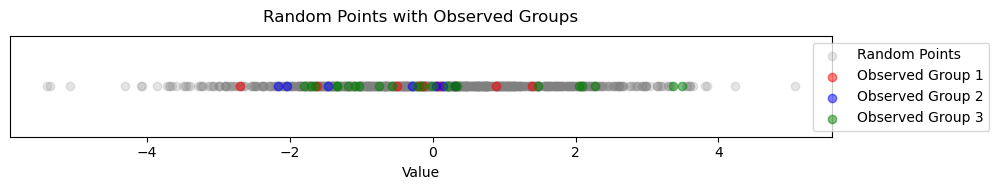

In [16]:
# Generating three groups of 50 observed points
observed_group1_s = tc.posterior["g1strictness"].values.mean(axis=(0, 1, 2, 4))
observed_group2_s = tc.posterior["g2strictness"].values.mean(axis=(0, 1, 2, 4))
observed_group3_s = tc.posterior["mstrictness"].values.mean(axis=(0, 1, 2, 4))

# Combine the groups into a list for easier plotting
observed_groups = [observed_group1_s, observed_group2_s, observed_group3_s]
colors = ["red", "blue", "green"]

# Creating the figure with a very small height
plt.figure(figsize=(10, 2))  # Width is 10, height is 1

# Plotting the 1000 randomly drawn points
plt.scatter(
    strictnesses,
    np.zeros_like(strictnesses),
    color="gray",
    label="Random Points",
    alpha=0.2,
)

# Plotting each observed group in different colors
for i, group in enumerate(observed_groups):
    plt.scatter(
        group,
        np.zeros_like(group),
        color=colors[i],
        label=f"Observed Group {i+1}",
        alpha=0.5,
    )

# Adding labels and title
plt.xlabel("Value")
plt.yticks([])  # Removing y-axis ticks
plt.title("Random Points with Observed Groups", pad=10)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), ncol=1)

# Adjusting layout to ensure the figure is tight
plt.tight_layout()

# Show the plot
plt.show()

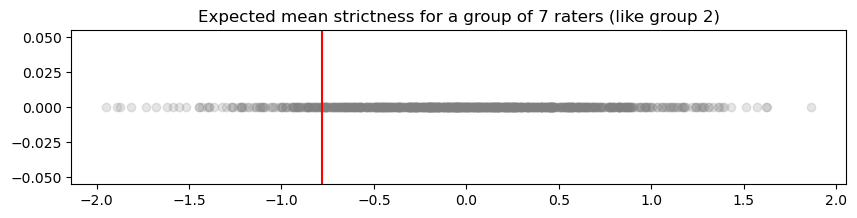

In [21]:
# sample random groups of raters, and check their mean strictness

# sample random strictness values, and highlight the real cases in there
random_sds = np.random.choice(
    np.ravel(tc.posterior["strictness_sd"].values),
    (1000, len(observed_group2_s)),
    replace=True,
)
strictness_groups = np.random.normal(0, random_sds).mean(axis=1)

# Creating the figure with a very small height
plt.figure(figsize=(10, 2))  # Width is 10, height is 1

# Plotting the 1000 randomly drawn points
plt.scatter(
    strictness_groups,
    np.zeros_like(strictness_groups),
    color="gray",
    label="Random Points",
    alpha=0.2,
)
plt.axvline(tc.posterior["g2strictness"].values.mean(), color="r")
plt.title("Expected mean strictness for a group of 7 raters (like group 2)")
plt.show()

## Check chauvinism

In [22]:
# might it be strictness? Check the means

for i in ["g1chauvinism", "g2chauvinism", "chauvinism_hum"]:
    print(f"{i} mean chauvinism: {tc.posterior[i].values.mean()}")

g1chauvinism mean chauvinism: 0.6762748727214202
g2chauvinism mean chauvinism: 0.8587254693497064
chauvinism_hum mean chauvinism: 1.013814821343574


In [23]:
# sample random strictness values, and highlight the real cases in there
random_sds = np.random.choice(
    np.ravel(tc.posterior["chauv_sd"].values), 1000, replace=True
)
random_means = np.random.choice(
    np.ravel(tc.posterior["chauv_mean"].values), 1000, replace=True
)
chauvinisms = np.random.normal(random_means, random_sds)

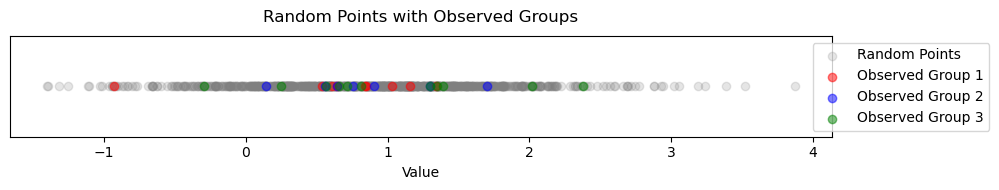

In [24]:
# Generating three groups of 50 observed points
observed_group1_c = tc.posterior["g1chauvinism"].values.mean(axis=(0, 1, 2, 4))
observed_group2_c = tc.posterior["g2chauvinism"].values.mean(axis=(0, 1, 2, 4))
observed_group3_c = tc.posterior["chauvinism_hum"].values.mean(axis=(0, 1, 2, 4))

# Combine the groups into a list for easier plotting
observed_groups = [observed_group1_c, observed_group2_c, observed_group3_c]
colors = ["red", "blue", "green"]

# Creating the figure with a very small height
plt.figure(figsize=(10, 2))  # Width is 10, height is 1

# Plotting the 1000 randomly drawn points
plt.scatter(
    chauvinisms,
    np.zeros_like(chauvinisms),
    color="gray",
    label="Random Points",
    alpha=0.2,
)

# Plotting each observed group in different colors
for i, group in enumerate(observed_groups):
    plt.scatter(
        group,
        np.zeros_like(group),
        color=colors[i],
        label=f"Observed Group {i+1}",
        alpha=0.5,
    )

# Adding labels and title
plt.xlabel("Value")
plt.yticks([])  # Removing y-axis ticks
plt.title("Random Points with Observed Groups", pad=10)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), ncol=1)

# Adjusting layout to ensure the figure is tight
plt.tight_layout()

# Show the plot
plt.show()

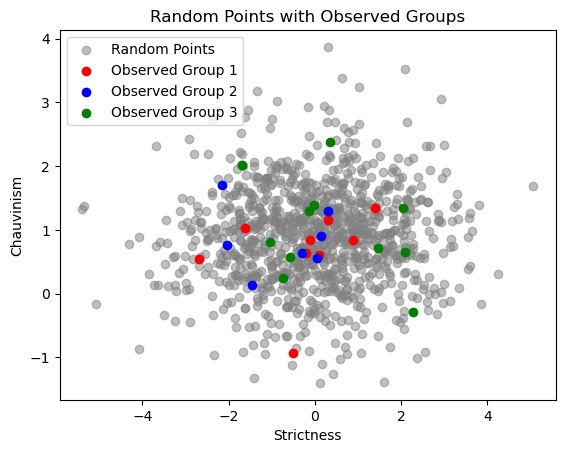

In [25]:
# combine


# Generating 1000 randomly drawn points from a normal distribution
random_points = np.array([strictnesses, chauvinisms])

# Generating three groups of 50 observed points
observed_group1 = np.array([observed_group1_s, observed_group1_c])
observed_group2 = np.array([observed_group2_s, observed_group2_c])
observed_group3 = np.array([observed_group3_s[:11], observed_group3_c])

# Plotting the 1000 randomly drawn points
plt.scatter(
    random_points[0, :],
    random_points[1, :],
    color="gray",
    alpha=0.5,
    label="Random Points",
)

# Plotting the three observed groups in different colors
plt.scatter(
    observed_group1[0, :], observed_group1[1, :], color="red", label="Observed Group 1"
)
plt.scatter(
    observed_group2[0, :], observed_group2[1, :], color="blue", label="Observed Group 2"
)
plt.scatter(
    observed_group3[0, :],
    observed_group3[1, :],
    color="green",
    label="Observed Group 3",
)

# Adding labels and title
plt.xlabel("Strictness")
plt.ylabel("Chauvinism")
plt.title("Random Points with Observed Groups")
plt.legend()

# Show the plot
plt.show()

## Check paper values

## First the intercepts

In [26]:
K = 5

mB = len(df.loc[df.group == "main"]["block"].unique())
g1B = len(df.loc[df.group == "group1"]["block"].unique())
g2B = len(df.loc[df.group == "group1"]["block"].unique())

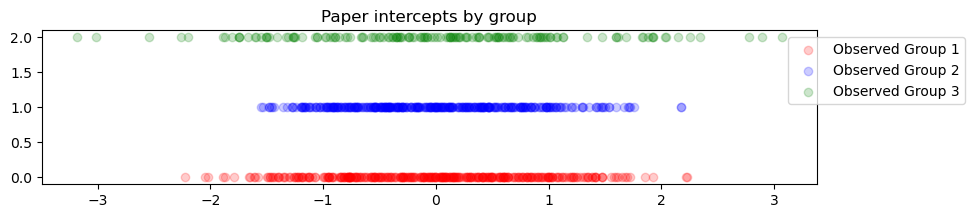

In [27]:
all_intercepts = tc.posterior["paper_intercepts"].mean(dim=["chain", "draw"]).values

g1_intercepts = all_intercepts[mB * K : (mB * K) + (g1B * K)]
g2_intercepts = all_intercepts[(mB * K) + (g1B * K) :]
g3_intercepts = all_intercepts[: mB * K]

# Creating the figure with a very small height
plt.figure(figsize=(10, 2))  # Width is 10, height is 1

observed_groups = [g1_intercepts, g2_intercepts, g3_intercepts]
colors = ["red", "blue", "green"]

# Plotting each observed group in different colors
for i, group in enumerate(observed_groups):
    plt.scatter(
        group,
        np.zeros_like(group) + i,
        color=colors[i],
        label=f"Observed Group {i+1}",
        alpha=0.2,
    )

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), ncol=1)
plt.title("Paper intercepts by group")
plt.show()

## The paper values

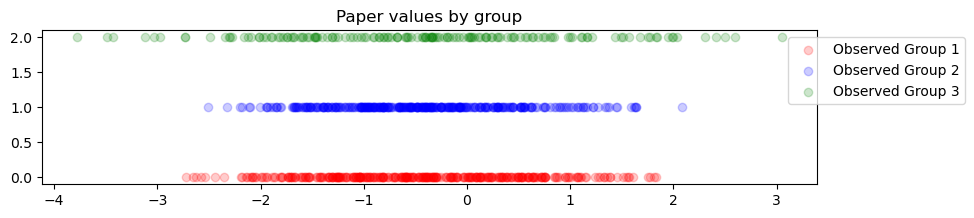

In [28]:
g1_papervals = np.ravel(
    tc.posterior["g1paper_values"].mean(dim=["chain", "draw"]).values
)
g2_papervals = np.ravel(
    tc.posterior["g2paper_values"].mean(dim=["chain", "draw"]).values
)
g3_papervals = np.ravel(
    tc.posterior["mpaper_values"].mean(dim=["chain", "draw"]).values
)

# Creating the figure with a very small height
plt.figure(figsize=(10, 2))  # Width is 10, height is 1

observed_groups = [g1_papervals, g2_papervals, g3_papervals]
colors = ["red", "blue", "green"]

# Plotting each observed group in different colors
for i, group in enumerate(observed_groups):
    plt.scatter(
        group,
        np.zeros_like(group) + i,
        color=colors[i],
        label=f"Observed Group {i+1}",
        alpha=0.2,
    )

plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), ncol=1)
plt.title("Paper values by group")
plt.show()

## Paper value estimates

C:\Users\conix\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
C:\Users\conix\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


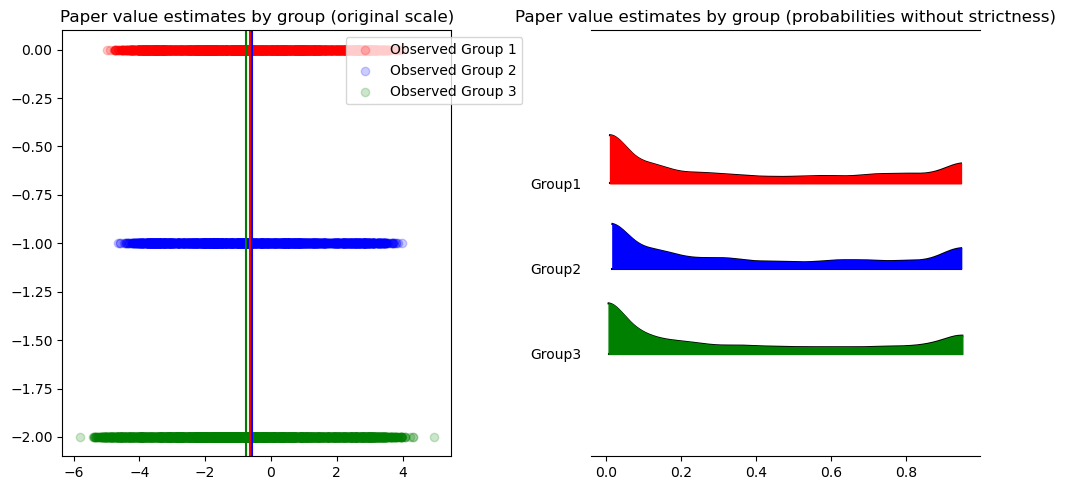

In [29]:
g1_latent = np.ravel(tc.posterior["g1latent"].mean(dim=["chain", "draw"]).values)
g2_latent = np.ravel(tc.posterior["g2latent"].mean(dim=["chain", "draw"]).values)
g3_latent = np.ravel(tc.posterior["mlatent"].mean(dim=["chain", "draw"]).values)

# Creating the figure with a very small height
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

observed_groups = [g1_latent, g2_latent, g3_latent]
colors = ["red", "blue", "green"]

# Plotting each observed group in different colors
for i, group in enumerate(observed_groups):
    ax[0].scatter(
        group,
        np.zeros_like(group) - i,
        color=colors[i],
        label=f"Observed Group {i+1}",
        alpha=0.2,
    )
    ax[0].axvline(group.mean(), color=colors[i])

ax[0].legend(loc="upper right", bbox_to_anchor=(1.2, 1), ncol=1)
ax[0].set_title("Paper value estimates by group (original scale)")

# # Plotting each observed group in different colors
# for i, group in enumerate(observed_groups):
#     sns.kdeplot(expit(group),  color=colors[i], label=f'Observed Group {i+1}', alpha = 1, ax=ax[1])

az.plot_forest(
    [
        np.array(expit(g1_latent)),
        np.array(expit(g2_latent)),
        np.array(expit(g3_latent)),
    ],
    legend=False,
    ridgeplot_overlap=2,
    colors=["red", "blue", "green"],
    kind="ridgeplot",
    ax=ax[1],
)

ax[1].set_title("Paper value estimates by group (probabilities without strictness)")
ax[1].set_yticklabels(["Group3", "Group2", "Group1"])
fig.tight_layout()
plt.show()

## Add strictness

In [30]:
g1LS = np.random.choice(observed_group1_s, len(g1_latent), replace=True)
g2LS = np.random.choice(observed_group2_s, len(g2_latent), replace=True)
g3LS = np.random.choice(observed_group3_s, len(g3_latent), replace=True)

g1R = np.random.binomial(1, expit(g1LS + g1_latent))
g2R = np.random.binomial(1, expit(g2LS + g2_latent))
g3R = np.random.binomial(1, expit(g3LS + g3_latent))


for i, j in enumerate([g1R, g2R, g3R]):
    print(f"Group{i+1} expected proportion: {j.mean()}")
print("")

Group1 expected proportion: 0.3922705314009662
Group2 expected proportion: 0.32546583850931676
Group3 expected proportion: 0.4175757575757576



**Conclusion: The low proportion of Group 2 is because the raters are a bit stricter. In other respects, the three groups are very similar. However, their strictness is still within the range of what we should expect.**

# Do rater scores and estimated paper values correlate?

In [4]:
# load the trace

trace_content_thurstonian_all = az.from_netcdf(
    r"C:\Users\conix\Documents\IIH_localtraces\trace_content_thurstonian_all.nc"
)

In [32]:
# convenience functions for linear regression

def standardize(data):
    out = (data - data.mean()) / np.std(data)
    return out


def linear_regr(X, Y):
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), Y.reshape(-1, 1))
    y_pred = model.predict(X.reshape(-1, 1))
    return y_pred

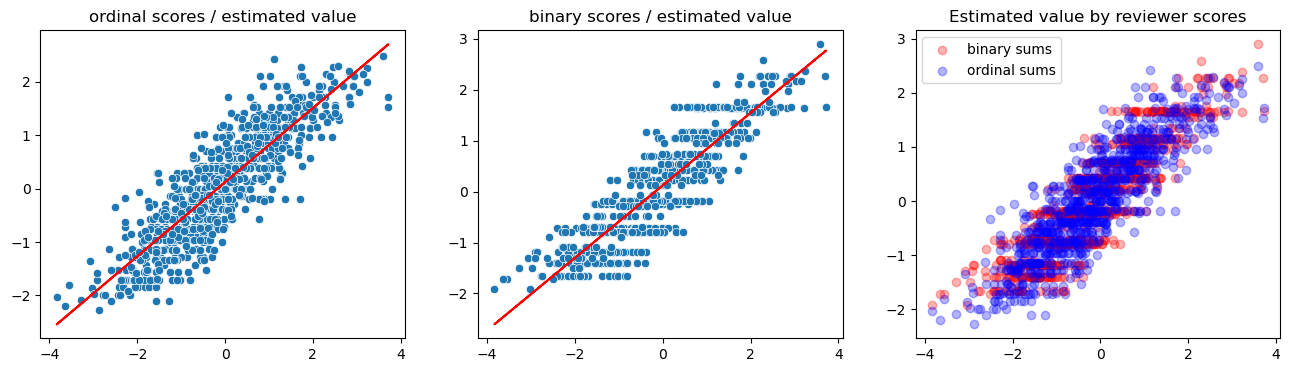

In [33]:
# now check for content model


df["abstract"] = df["abstract"].astype("str")
scores = {i: [] for i in ["group1", "group2", "main"]}
for i in ["group1", "group2", "main"]:
    for j in range(2):
        dfx = df.loc[df.group == i].copy()
        mscores = (
            dfx.sort_values(["block", "abstract"])
            .groupby("abstract", sort=False)[["ordinal", "binary"]]
            .sum()
            .values
        )
        results = standardize(mscores[:, j])
        scores[i].append(results)

mpaper_means = np.ravel(
    trace_content_thurstonian_all.posterior["mpaper_values"]
    .mean(dim=["chain", "draw"])
    .values
)
g1paper_means = np.ravel(
    trace_content_thurstonian_all.posterior["g1paper_values"]
    .mean(dim=["chain", "draw"])
    .values
)
g2paper_means = np.ravel(
    trace_content_thurstonian_all.posterior["g2paper_values"]
    .mean(dim=["chain", "draw"])
    .values
)

val_estimates = np.concatenate([g1paper_means, g2paper_means, mpaper_means])
binary_scores = np.concatenate([i[1] for i in scores.values()])
ordinal_scores = np.concatenate([i[0] for i in scores.values()])

fig, ax = plt.subplots(ncols=3, figsize=(16, 4))


# normalize reviewer scores so binary and ordinal are on the same scale

ax[2].scatter(y=binary_scores, x=val_estimates, color="r", alpha=0.3)
ax[2].scatter(y=ordinal_scores, x=val_estimates, color="b", alpha=0.3)
ax[2].legend(["binary sums", "ordinal sums"])
ax[2].set_title("Estimated value by reviewer scores")


# get the regression lines

y_ord = linear_regr(val_estimates, ordinal_scores)
y_bin = linear_regr(val_estimates, binary_scores)

sns.scatterplot(y=ordinal_scores, x=val_estimates, ax=ax[0])
ax[0].plot(val_estimates, y_ord, color="r")
ax[0].set_title("ordinal scores / estimated value")

sns.scatterplot(y=binary_scores, x=val_estimates, ax=ax[1])
ax[1].plot(val_estimates, y_bin, color="r")
ax[1].set_title("binary scores / estimated value")

plt.show()

In [5]:
# chauvinism model
# load trace
trace_chauvinism_thurstonian_all = az.from_netcdf(
    r"C:\Users\conix\Documents\IIH_localtraces\trace_chauvinism_thurstonian_all_Final.nc"
)

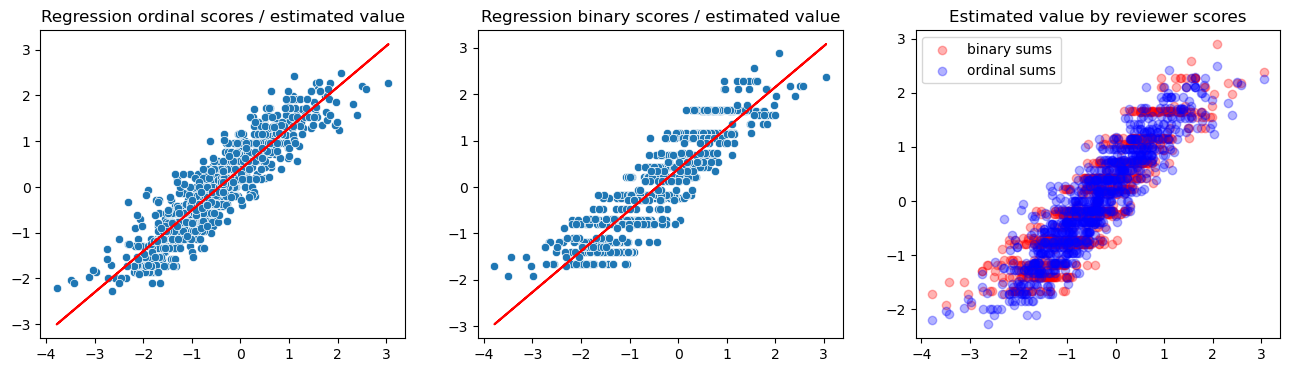

In [35]:
df["abstract"] = df["abstract"].astype("str")
scores = {i: [] for i in ["group1", "group2", "main"]}
for i in ["group1", "group2", "main"]:
    for j in range(2):
        dfx = df.loc[df.group == i].copy()
        mscores = (
            dfx.sort_values(["block", "abstract"])
            .groupby("abstract", sort=False)[["ordinal", "binary"]]
            .sum()
            .values
        )
        results = standardize(mscores[:, j])
        scores[i].append(results)

mpaper_means = np.ravel(
    trace_chauvinism_thurstonian_all.posterior["mpaper_values"]
    .mean(dim=["chain", "draw"])
    .values
)
g1paper_means = np.ravel(
    trace_chauvinism_thurstonian_all.posterior["g1paper_values"]
    .mean(dim=["chain", "draw"])
    .values
)
g2paper_means = np.ravel(
    trace_chauvinism_thurstonian_all.posterior["g2paper_values"]
    .mean(dim=["chain", "draw"])
    .values
)

val_estimates = np.concatenate([g1paper_means, g2paper_means, mpaper_means])
binary_scores = np.concatenate([i[1] for i in scores.values()])
ordinal_scores = np.concatenate([i[0] for i in scores.values()])

fig, ax = plt.subplots(ncols=3, figsize=(16, 4))


# normalize reviewer scores so binary and ordinal are on the same scale

ax[2].scatter(y=binary_scores, x=val_estimates, color="r", alpha=0.3)
ax[2].scatter(y=ordinal_scores, x=val_estimates, color="b", alpha=0.3)
ax[2].legend(["binary sums", "ordinal sums"])
ax[2].set_title("Estimated value by reviewer scores")


# get the regression lines

y_ord = linear_regr(val_estimates, ordinal_scores)
y_bin = linear_regr(val_estimates, binary_scores)

sns.scatterplot(y=ordinal_scores, x=val_estimates, ax=ax[0])
ax[0].plot(val_estimates, y_ord, color="r")
ax[0].set_title("Regression ordinal scores / estimated value")

sns.scatterplot(y=binary_scores, x=val_estimates, ax=ax[1])
ax[1].plot(val_estimates, y_bin, color="r")
ax[1].set_title("Regression binary scores / estimated value")

plt.show()

In [6]:
# fields model
# load trace
trace_field_thurstonian_all = az.from_netcdf(
    r"C:\Users\conix\Documents\IIH_localtraces\trace_field_thurstonian_all.nc"
)

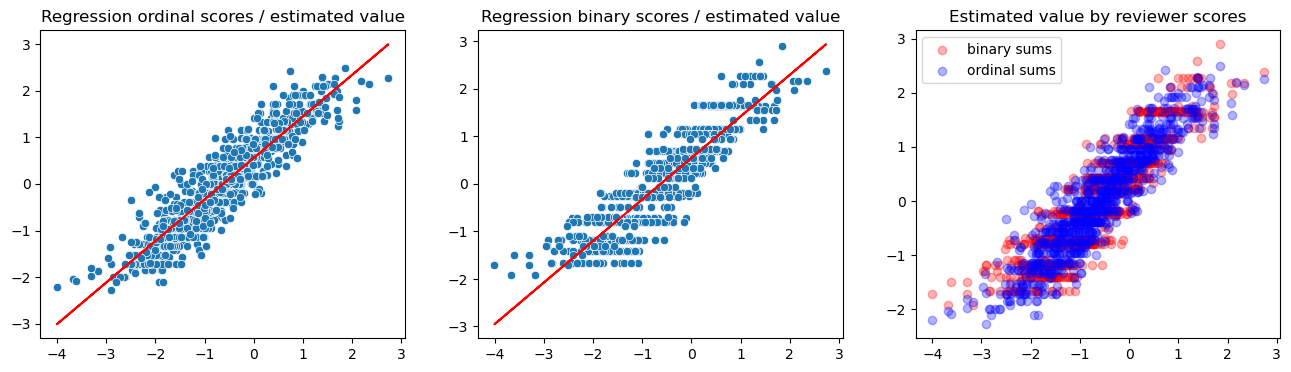

In [37]:
df["abstract"] = df["abstract"].astype("str")
scores = {i: [] for i in ["group1", "group2", "main"]}
for i in ["group1", "group2", "main"]:
    for j in range(2):
        dfx = df.loc[df.group == i].copy()
        mscores = (
            dfx.sort_values(["block", "abstract"])
            .groupby("abstract", sort=False)[["ordinal", "binary"]]
            .sum()
            .values
        )
        results = standardize(mscores[:, j])
        scores[i].append(results)

mpaper_means = np.ravel(
    trace_field_thurstonian_all.posterior["mpaper_values"]
    .mean(dim=["chain", "draw"])
    .values
)
g1paper_means = np.ravel(
    trace_field_thurstonian_all.posterior["g1paper_values"]
    .mean(dim=["chain", "draw"])
    .values
)
g2paper_means = np.ravel(
    trace_field_thurstonian_all.posterior["g2paper_values"]
    .mean(dim=["chain", "draw"])
    .values
)

val_estimates = np.concatenate([g1paper_means, g2paper_means, mpaper_means])
binary_scores = np.concatenate([i[1] for i in scores.values()])
ordinal_scores = np.concatenate([i[0] for i in scores.values()])

fig, ax = plt.subplots(ncols=3, figsize=(16, 4))


# normalize reviewer scores so binary and ordinal are on the same scale

ax[2].scatter(y=binary_scores, x=val_estimates, color="r", alpha=0.3)
ax[2].scatter(y=ordinal_scores, x=val_estimates, color="b", alpha=0.3)
ax[2].legend(["binary sums", "ordinal sums"])
ax[2].set_title("Estimated value by reviewer scores")


# get the regression lines

y_ord = linear_regr(val_estimates, ordinal_scores)
y_bin = linear_regr(val_estimates, binary_scores)

sns.scatterplot(y=ordinal_scores, x=val_estimates, ax=ax[0])
ax[0].plot(val_estimates, y_ord, color="r")
ax[0].set_title("Regression ordinal scores / estimated value")

sns.scatterplot(y=binary_scores, x=val_estimates, ax=ax[1])
ax[1].plot(val_estimates, y_bin, color="r")
ax[1].set_title("Regression binary scores / estimated value")

plt.show()

# Logistic regressions

The thurstonian models we use are very complex. Although they should make more sense than simple logistic regressions, it is good to check whether such logistic regressions (or even simple correlations), with the appropriate variables selected by our DAG, give similar results. Note: these outcomes are difficult to compare given that they are on different scales. But it should be possible to check whether the relations between parameters are somewhat similar.

## Chauvinism

In [52]:
# first calculate simple pearson's correlation
# we expect a weak correlation, given that the hyperprior mean is positive

x = df.chauvinism.values
y = df.binary.values

pearson_corr = np.corrcoef(x, y)[0, 1]
print(f"Pearson's correlation: {pearson_corr}")

Pearson's correlation: 0.1055257006232722


In [41]:
df['field'] = df.field.astype('category')
df['new_rater_disc'] = df.new_rater_disc.astype('category')
df['abstract'] = df['abstract'].astype('category')
df['rater'] = df.rater.astype('category')
coords = { 'fields_c':fields_names, 'rater_fields_c': rater_fields_names, 'abstracts_c' :df['abstract'].cat.categories,
'raters_c': df['rater'].cat.categories}

with pm.Model(coords=coords) as chauvinism_model_all:

    FIELD = pm.MutableData('FIELD', df.field.astype('category').cat.codes.values)
    RATER_FIELD = pm.MutableData('RATER_FIELD', df.new_rater_disc.astype('category').cat.codes.values)
    CHAUVINISM = pm.MutableData('CHAUVINISM', df.chauvinism.values)
    ABSTRACT = pm.MutableData('ABSTRACT', df['abstract'].cat.codes.values)
    RATER = pm.MutableData('RATER', df['rater'].cat.codes.values)

    intercept = pm.Normal('intercept',0,1, dims = 'abstracts_c')
    field = pm.Normal('field', 0,1, dims = 'fields_c')
    rater_field = pm.Normal('rater_field', 0,1, dims = 'rater_fields_c')
    chauvinism = pm.Normal('chauvinism',0,1, dims = 'raters_c')
    strictness = pm.Normal('strictness',0,1,dims = 'raters_c')    

    lm = intercept[ABSTRACT] +  field[FIELD] + rater_field[RATER_FIELD] + strictness[RATER] + chauvinism[RATER] * CHAUVINISM
    y = pm.Bernoulli('y', logit_p = lm, observed = df['binary'].values)


In [43]:
with chauvinism_model_all:
    trace_chauvinism_model_all = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, field, rater_field, chauvinism, strictness]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 246 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [44]:
# trace_chauvinism_model_all.to_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_chauvinism_model_all.nc")
trace_chauvinism_model_all = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_chauvinism_model_all.nc")

'C:\\Users\\conix\\Documents\\IIH_localtraces\\trace_chauvinism_model_all.nc'

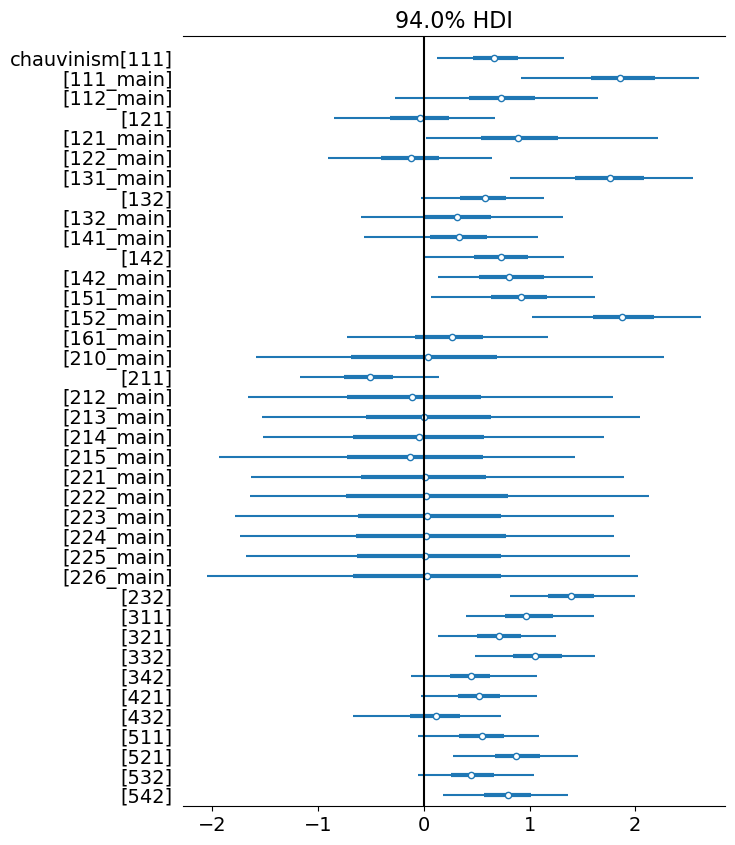

In [46]:
fig, ax = plt.subplots(figsize = (7,10))
az.plot_forest(trace_chauvinism_model_all, var_names = ['chauvinism'],combined = True,ax=ax)
ax.axvline(0, color = 'black')
plt.show()

## Field

In [57]:
# crosstab field and binary
# these proportions mirror the outcomes of the thurstonian model

pd.crosstab(df.binary, df.field, normalize = "columns")

field,History,Linguistics,Literature,Philosophy,Religion
binary,,,,,
0,0.617347,0.510204,0.741497,0.577098,0.619615
1,0.382653,0.489796,0.258503,0.422902,0.380385


In [48]:
df['sex'] = df.sex.astype('category')
df['weird'] = df.weird.astype('category')
df['abstract'] = df['abstract'].astype('category')
df['rater'] = df.rater.astype('category')
df['new_rater_disc'] = df.new_rater_disc.astype('category')

coords = { 'fields_c':fields_names, 'rater_fields_c': rater_fields_names, 'weird_c': ['not weird','weird'], 'gender_c':['female','male'] , 'abstracts_c' :df['abstract'].cat.categories, 'raters_c': df['rater'].cat.categories}

with pm.Model(coords=coords) as field_model:

    FIELD = pm.MutableData('FIELD', df.field.astype('category').cat.codes.values)
    GENDER = pm.MutableData('GENDER', df.sex.astype('category').cat.codes.values)
    WEIRD = pm.MutableData('WEIRD', df.weird.astype('category').cat.codes.values)
    ABSTRACT = pm.MutableData('ABSTRACT', df['abstract'].cat.codes.values)
    RATER = pm.MutableData('RATER', df['rater'].cat.codes.values)
    RATER_FIELD = pm.MutableData('RATER_FIELD', df.new_rater_disc.astype('category').cat.codes.values)

    
    intercept = pm.Normal('intercept',0,1, dims = 'abstracts_c')
    fields = pm.Normal('fields', 0,1, dims = 'fields_c')
    gender = pm.Normal('gender', 0,1, dims = 'gender_c')
    weird = pm.Normal('weird',0,1, dims = 'weird_c')
    rater_field = pm.Normal('rater_field', 0,1, dims = 'rater_fields_c')
    strictness = pm.Normal('strictness',0,1,dims = 'raters_c')    


    lm = intercept[ABSTRACT] + fields[FIELD] + rater_field[RATER_FIELD] + gender[GENDER] + weird[WEIRD] + strictness[RATER]
    y = pm.Bernoulli('y', logit_p = lm, observed = df['binary'].values)

    

In [49]:
with field_model:
    trace_field_model_all = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, fields, gender, weird, rater_field, strictness]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 470 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
trace_field_model_all.to_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_field_model_all.nc")
# trace_field_model_all = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_field_model_all.nc")

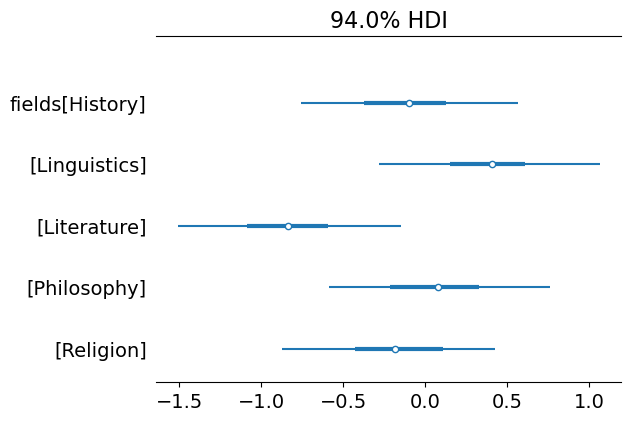

In [51]:
az.plot_forest(trace_field_model_all, var_names = ['fields'], combined = True)
plt.show()

## Content

In [93]:
df = df.sort_values(by = ['group','block','abstract','rater'])
df.doctype = df.doctype.replace({'Article':0, 'Book':1})
df['rater'] = df.rater.astype('category').values
df['abstract'] = df['abstract'].astype('category').values

coords = {'fields_c':fields_names,'bin_c': content_params}
J = len(df['rater'].unique())

# have to sort by group first, to make sure I can compare with the thurstonian model, where they are analysed separately

with pm.Model(coords=coords) as content_model_all:

    # content codes without fiction
    BIN_DATA = pm.MutableData('BIN_DATA', df[content_params].values)
    FIELD = pm.MutableData('FIELD', df.field.astype('category').cat.codes.values)
    RATER = pm.MutableData('RATER', df['rater'].cat.codes.values)
    ABSTRACT = pm.MutableData('ABSTRACT', df['abstract'].cat.codes.values)
    
    content = pm.Normal('content',0,1, dims = 'bin_c')
    intercept = pm.Normal('intercept',0,1, shape = len(df['abstract'].unique())) 
    field = pm.Normal('field', 0,1, dims = 'fields_c')
    strictness = pm.Normal('strictness',0,1,shape = (J))
    lm = intercept[ABSTRACT] + pt.dot(BIN_DATA, content) + field[FIELD] + strictness[RATER]
    y = pm.Bernoulli('y', logit_p = lm, observed = df['binary'].values)



In [95]:
with content_model_all:
    trace_content_model_all = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [content, intercept, field, strictness]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 166 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [96]:
trace_content_model_all.to_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_content_model_all.nc")
# trace_content_model_all = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_content_model_all.nc")

'C:\\Users\\conix\\Documents\\IIH_localtraces\\trace_content_model_all.nc'

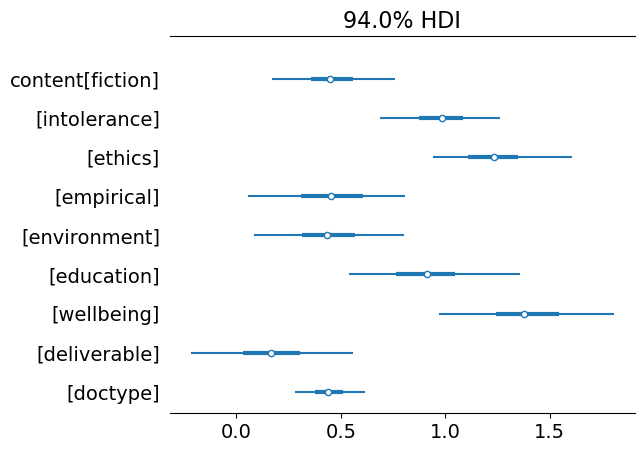

In [97]:
az.plot_forest(trace_content_model_all,var_names = 'content', combined = True)
plt.show()

# Check strictness

Try running the models setting one fixed rater's strictness to 0. Is this necessary to define the model?

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

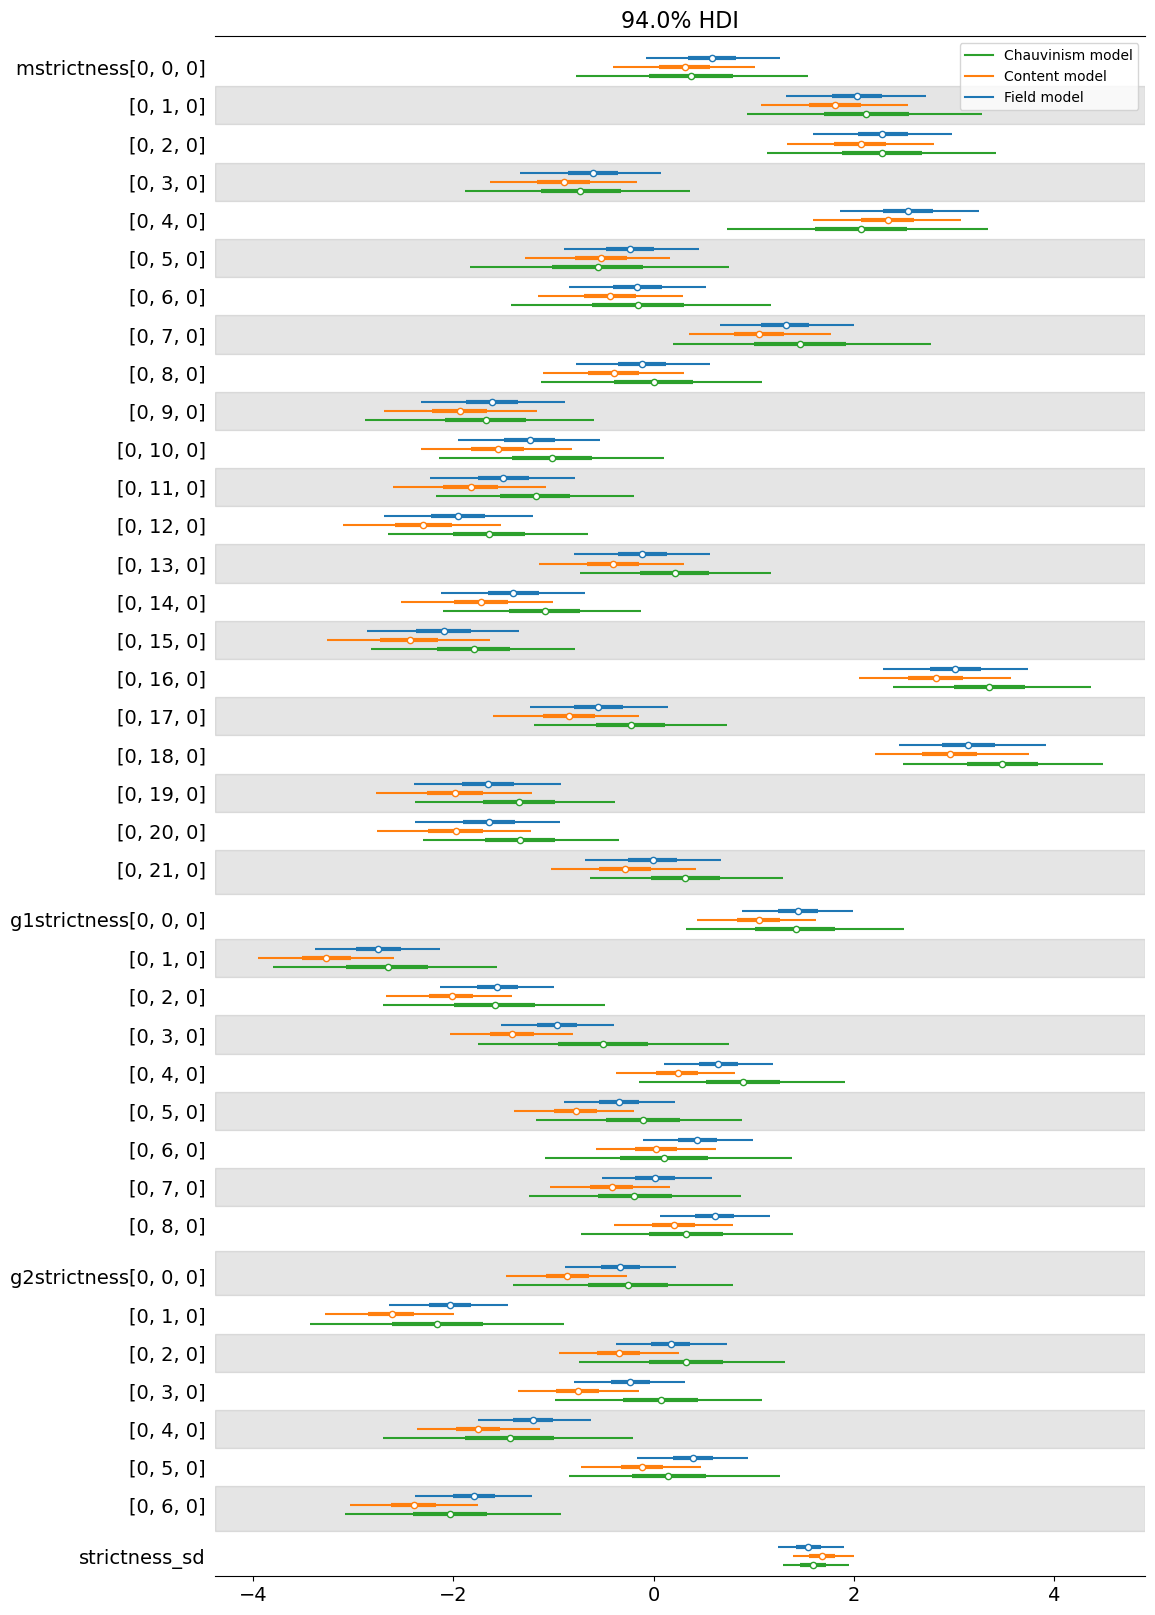

In [8]:
models = [
    trace_field_thurstonian_all,
    trace_content_thurstonian_all,
    trace_chauvinism_thurstonian_all,
]
az.plot_forest(
    models,
    var_names=["mstrictness", "g1strictness", "g2strictness", "strictness_sd"],
    model_names=["Field model", "Content model", "Chauvinism model"],
    combined=True,
    figsize=(12, 20),
)

In [13]:
# do they all have a mean of 0?

groups = ["mstrictness", "g1strictness", "g2strictness"]
for i in models:
    means = [i.posterior[j].mean().values for j in groups]
    print(f"Model strictness mean: {np.mean(np.array(means))}")
    print(means)

# the content model seems to differ from the other two the most

Model strictness mean: -0.3307358443448703
[array(0.00160616), array(-0.27471851), array(-0.71909518)]
Model strictness mean: -0.7551459980606247
[array(-0.28355433), array(-0.71416804), array(-1.26771561)]
Model strictness mean: -0.2963906201602596
[array(0.1322862), array(-0.2570467), array(-0.76441136)]


# Check content ppc

Hard to say how correct content posterior samples are, because they show content codes in isolation, while most documents have multiple. One way of checking this for at least some, is to see whether posterior predictive samples are plausible compared to observed cases with only one code.


In [ ]:
with open(r"C:\Users\conix\Documents\IIH_localtraces\contents_array.pkl", 'rb') as file:
    # Use pickle.load to deserialize the dictionary
    contents_array = pickle.load(file)

content_keys = ['fiction',
 'intolerance',
 'ethics',
 'empirical',
 'environment',
 'education',
 'wellbeing',
 'deliverable',
'No code',
'Book',] 

content_codes = [
    "fiction",
    "intolerance",
    "ethics",
    "empirical",
    "environment",
    "education",
    "wellbeing",
    "deliverable",
]

trace_content_thurstonian_all = az.from_netcdf(r"C:\Users\conix\Documents\IIH_localtraces\trace_content_thurstonian_all.nc")

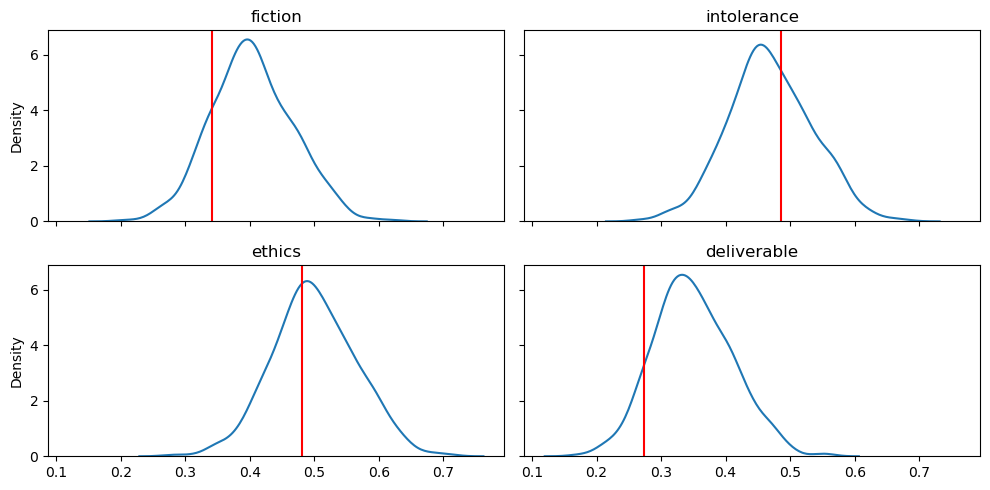

In [29]:
# check the content codes for which there are isolated instances

content_props_dct = {}
for i in content_keys[:-2]:
    other_columns = [col for col in content_keys[:-2] if col != i]
    non_zero = len(df.loc[(df[i] == 1) & ((df[other_columns] == 0).all(axis=1))])
    if non_zero > 0:
        content_props_dct[i] = df.loc[(df[i] == 1) & ((df[other_columns] == 0).all(axis=1))]['binary'].mean()

# now check ppc
# plot the kdeplot of expected proportions, and indicate the observed value in red

positions = [0,1,2,7]


fig, axs = plt.subplots(2,2, figsize = (10,5), sharey = True, sharex = True)

for ax, (j,i) in zip(axs.flat, enumerate(positions)):
    sns.kdeplot(contents_array[i,:], ax=ax)
    ax.set_title(content_keys[i])
    ax.axvline(list(content_props_dct.values())[j], color = 'r')

fig.tight_layout()

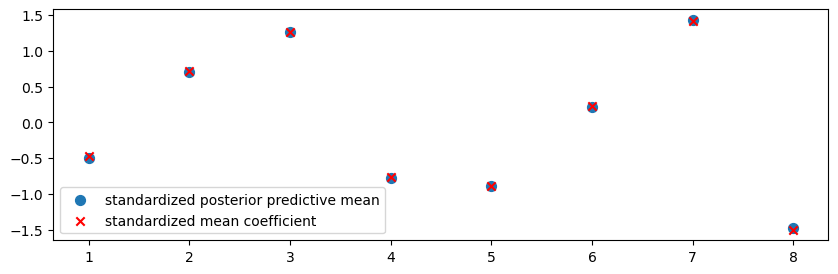

In [64]:
# sanity check: make sure a higher coefficient leads to more relevant docs

# put them on the same scale

def standardize(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    return (arr - mean) / std

plt.figure(figsize = (10,3))

# the posterior predictive means
plt.scatter(x = np.arange(1,9), y = standardize(contents_array[:-2,:].mean(axis = 1)), s = 50)

# the coefficients
plt.scatter(x = np.arange(1,9), y = standardize(trace_content_thurstonian_all.posterior['content'][:,:,:].mean(axis = (0,1)).values), marker = 'x',color = 'r')

plt.legend(['standardized posterior predictive mean', 'standardized mean coefficient'])
plt.show()
